In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
import random
import matplotlib.pyplot as plt

In [2]:
### Training insturction example
tr_or_pr = 0
st = 0.001 # starting time [s], do not change!
dt = 0.001 # timestep [s], do not change!
nt = 100 # number of timestep [-], do not change!

epochs = 2000 # you can change it
checkpoint_path =  "/home/ubuntu/dambreak/ML/checkpoints_test/cp.ckpt" # you should change it

In [3]:
if (tr_or_pr == 0): # Training
    filename_grid = '/home/ubuntu/dambreak/ML/centres.csv' # you should change the directory
    Grid = pd.read_csv(filename_grid, header = None)
    Grid_slice = Grid.drop(0, axis=0).astype(np.float32)
    Grid_tf = tf.reshape(Grid_slice, shape =[-1,4])
    Grid_np = Grid_tf.numpy()
    Ngrid_xnp = np.array(200*Grid_np[:,1:2]+0.51, dtype=np.int64) #tf 데이터는 for 문에서 특히 느림 (why?)
    Ngrid_ynp = np.array(200*Grid_np[:,2:3]+0.51, dtype=np.int64)
    grid_number = int(40000)
    grid_number_x = int(200)
    grid_number_y = int(200)
    gc = int(40000)

### preprocessing: from OpenFOAM t-data to ML dataset
    for nti in range(0,nt):
        ### Dataset load (OpenFOAM results file)
        tnow = st + dt*nti
        tnow = "{:g}".format(tnow)
        filename_openfoam = '/home/ubuntu/dambreak/ML/traindata%s.csv'%tnow

        openfoam = pd.read_csv(filename_openfoam, header = None)
        openfoam_slice = openfoam.drop(0, axis=0).astype(np.float32)
        openfoam_tf = tf.reshape(openfoam_slice, shape =[-1,7])
        openfoam_np = openfoam_tf.numpy()

        alpha_np = openfoam_np[:,1:2]
        p_np = openfoam_np[:,2:3]
        ph_np = openfoam_np[:,3:4]
        U_np = openfoam_np[:,4:6]

        ### domain matrix
        alpha_matrix = np.ones([200,200])
        p_matrix = np.ones([200,200])
        ph_matrix = np.ones([200,200])
        ux_matrix = np.ones([200,200])
        uy_matrix = np.ones([200,200])

        for i in range(0, grid_number):
            ngrid_x = Ngrid_xnp[i]
            ngrid_y = Ngrid_ynp[i]
            alpha_matrix[ngrid_x-1,ngrid_y-1] = alpha_np[i,0]
            p_matrix[ngrid_x-1,ngrid_y-1] = p_np[i,0]
            ph_matrix[ngrid_x-1,ngrid_y-1] = ph_np[i,0]
            ux_matrix[ngrid_x-1,ngrid_y-1] = U_np[i,0]
            uy_matrix[ngrid_x-1,ngrid_y-1] = U_np[i,1]

        ### data smoothing (do not change!)
        ux_matrix = ux_matrix * alpha_matrix
        uy_matrix = uy_matrix * alpha_matrix
        
        globals()['alpha_matrix_'+str(tnow)] = alpha_matrix
        globals()['p_matrix_'+str(tnow)] = p_matrix
        globals()['ph_matrix_'+str(tnow)] = ph_matrix
        globals()['ux_matrix_'+str(tnow)] = ux_matrix
        globals()['uy_matrix_'+str(tnow)] = uy_matrix

        ### ML dataset production (features)
        ngrid_x_zp = grid_number_x + 2; ngrid_y_zp = grid_number_y +2

        p_ml = np.ones([grid_number, 5]); ph_ml = np.ones([grid_number, 5]); ux_ml = np.ones([grid_number, 5]); uy_ml = np.ones([grid_number, 5]); alpha_ml = np.ones([grid_number, 5])
        
        ### zero padding
        p_matrix_zp = np.zeros([ngrid_x_zp,ngrid_y_zp]); ph_matrix_zp = np.zeros([ngrid_x_zp,ngrid_y_zp]); ux_matrix_zp = np.zeros([ngrid_x_zp,ngrid_y_zp]); uy_matrix_zp = np.zeros([ngrid_x_zp,ngrid_y_zp]); alpha_matrix_zp = np.ones([ngrid_x_zp,ngrid_y_zp])+np.ones([ngrid_x_zp,ngrid_y_zp]) # zero padding
        p_matrix_zp[1:ngrid_x_zp-1, 1:ngrid_y_zp-1] = p_matrix; ph_matrix_zp[1:ngrid_x_zp-1, 1:ngrid_y_zp-1] = ph_matrix; ux_matrix_zp[1:ngrid_x_zp-1, 1:ngrid_y_zp-1] = ux_matrix; uy_matrix_zp[1:ngrid_x_zp-1, 1:ngrid_y_zp-1] = uy_matrix; alpha_matrix_zp[1:ngrid_x_zp-1, 1:ngrid_y_zp-1] = alpha_matrix

        
        k = 0
        for i in range(1, 201):
            for j in range(1,201):
                p_ml[k,0] = p_matrix_zp[i,j]; p_ml[k,1] = p_matrix_zp[i-1,j]; p_ml[k,2] = p_matrix_zp[i+1,j]; p_ml[k,3] = p_matrix_zp[i,j-1]; p_ml[k,4] = p_matrix_zp[i,j+1];
                ph_ml[k,0] = ph_matrix_zp[i,j]; ph_ml[k,1] = ph_matrix_zp[i-1,j]; ph_ml[k,2] = ph_matrix_zp[i+1,j]; ph_ml[k,3] = ph_matrix_zp[i,j-1]; ph_ml[k,4] = ph_matrix_zp[i,j+1];
                ux_ml[k,0] = ux_matrix_zp[i,j]; ux_ml[k,1] = ux_matrix_zp[i-1,j]; ux_ml[k,2] = ux_matrix_zp[i+1,j]; ux_ml[k,3] = ux_matrix_zp[i,j-1]; ux_ml[k,4] = ux_matrix_zp[i,j+1];
                uy_ml[k,0] = uy_matrix_zp[i,j]; uy_ml[k,1] = uy_matrix_zp[i-1,j]; uy_ml[k,2] = uy_matrix_zp[i+1,j]; uy_ml[k,3] = uy_matrix_zp[i,j-1]; uy_ml[k,4] = uy_matrix_zp[i,j+1];
                alpha_ml[k,0] = alpha_matrix_zp[i,j]; alpha_ml[k,1] = alpha_matrix_zp[i-1,j]; alpha_ml[k,2] = alpha_matrix_zp[i+1,j]; alpha_ml[k,3] = alpha_matrix_zp[i,j-1]; alpha_ml[k,4] = alpha_matrix_zp[i,j+1];
                k=k+1
        
        globals()['ml_dataset_'+str(nti)] = np.concatenate((alpha_ml,ph_ml,ux_ml,uy_ml),axis = 1) # 각 time series data 저장

    ### ML dataset production (labels)
    ml_dataset_inp = globals()['ml_dataset_'+str(0)][0:gc,:]
    ntd = nt - 1
    for nti in range(0,ntd):
        globals()['ml_dataset_diff_'+str(nti)] = globals()['ml_dataset_'+str(nti+1)] - globals()['ml_dataset_'+str(nti)]

    ml_dataset_diff = globals()['ml_dataset_diff_'+str(0)][0:gc,:]
    ntdd = ntd - 1
    for nti in range(0,ntdd):
        ml_dataset_diff = np.concatenate((ml_dataset_diff, globals()['ml_dataset_diff_'+str(nti+1)][0:gc,:]), axis = 0)
        ml_dataset_inp = np.concatenate((ml_dataset_inp, globals()['ml_dataset_'+str(nti+1)][0:gc,:]), axis = 0)


    ml_dataset = np.concatenate((ml_dataset_diff[:,0:1],ml_dataset_diff[:,5:6],ml_dataset_diff[:,10:11],ml_dataset_diff[:,15:16],ml_dataset_inp),axis = 1)
    
    ### normalization
    gct = gc * (nt-1) # gc: grid center (default gc = gtot)
    dataset = pd.DataFrame(ml_dataset[0:gct,4:24])

    train_stats = dataset.describe()
    train_stats = train_stats.transpose()

    train_labels_a = ml_dataset[0:gct,0:1]
    #train_labels_p = ml_dataset[0:gct,1:2] # I recommend to ignoring p-variable
    train_labels_ph = ml_dataset[0:gct,1:2]
    train_labels_u = ml_dataset[0:gct,2:3]
    train_labels_v = ml_dataset[0:gct,3:4]
    train_labels = np.concatenate((train_labels_a, train_labels_ph, train_labels_u,train_labels_v),axis=1)

    labels = pd.DataFrame(train_labels)

    labels_stats = labels.describe()
    labels_stats = labels_stats.transpose()

    def norm(x):
        return (x-train_stats['mean'])/train_stats['std']
    def norm_label(x):
        return (x-labels_stats['mean'])/labels_stats['std']
    def denorm_label(x):
        return x*labels_stats['std']+labels_stats['mean']

    normed_train_data = norm(dataset)
    normed_train_data_re= tf.reshape(normed_train_data, shape=[-1,20])

    normed_train_labels = norm_label(labels)
    denorm_test = denorm_label(normed_train_labels)

    
    train_labels = tf.reshape(normed_train_labels, shape = [-1,4])
    train_labels = np.reshape(train_labels, (-1,4))

    dataset_re = tf.reshape(dataset, shape=[-1,20])

    # input data (normed, raw)
    x_sum = np.concatenate((normed_train_data_re, dataset_re[0:gct,0:1], dataset_re[0:gct,5:6], dataset_re[0:gct,10:11], dataset_re[0:gct,15:16]),axis=1)
    # output data
    y_sum = train_labels

    from sklearn.model_selection import train_test_split
    x, x_val, y, y_val = train_test_split(x_sum,y_sum,test_size=0.2, random_state = 1004)
    x_pinn = x_sum  # x_pinn, y_pinn for test
    y_pinn = y_sum

    # loss_tracker for monotoring during training
    loss_tracker = keras.metrics.Mean(name="val_loss")
    #loss_tracker_2 = keras.metrics.Mean(name="loss")
    loss_tracker_3 = keras.metrics.Mean(name="loss")
    mae_metric = keras.metrics.MeanAbsoluteError(name="mae")

    net_ph = keras.Sequential(
        [
            layers.Dense(512, activation='relu', input_shape=(20,)),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(1)   
        ],
        name="net_ph",
    )
    
    net_p = keras.Sequential(
        [
            layers.Dense(512, activation='relu', input_shape=(20,)),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(1)     
        ],
        name="net_p",
    )
    
    net_u = keras.Sequential(
        [
            layers.Dense(512, activation='relu', input_shape=(20,)),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(1)  
        ],
        name="net_u",
    )
    
    net_v = keras.Sequential(
        [
            layers.Dense(512, activation='relu', input_shape=(20,)),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(1)  
        ],
        name="net_v",
    )
    
    net_a = keras.Sequential(
        [
            layers.Dense(512, activation='relu', input_shape=(20,)),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(1)  
        ],
        name="net_a",
    )
         
    class FVMN_PINNs(keras.Model):
        def __init__(self, net_a, net_ph,net_u, net_v, Rs, x_val=x_val, y_val=y_val, x_pinn=x_pinn, y_pinn=y_pinn):
            super(FVMN_PINNs, self).__init__()          
            self.net_a = net_a
            #self.net_p = net_p
            self.net_ph = net_ph
            self.net_u = net_u
            self.net_v = net_v
            self.Rs = Rs
            self.x_val = x_val
            self.y_val = y_val
            self.x_pinn = x_pinn
            self.y_pinn = y_pinn
        
        def call(self,x):
            x = self.net_a(x)
            #x = self.net_p(x)
            x = self.net_ph(x)
            x = self.net_u(x)
            x = self.net_v(x)
       
        def train_step(self, data):
            x_pre, y = data
            # the order of the variables depends on the dataset.
            x = x_pre[:,0:20]
            x_ex = x_pre[:,20:24]
            x_ex = tf.cast(x_ex, dtype='float32')
            
            y_a = y[:,0:1]
            #y_p = y[:,1:2]
            y_ph = y[:,1:2]
            y_u = y[:,2:3] 
            y_v = y[:,3:4]
            
            with tf.GradientTape(persistent=True) as tape:
                #multi grads calculation: persistent=True
                y_pred_a = self.net_a(x)
                #y_pred_p = self.net_p(x)
                y_pred_ph = self.net_ph(x)
                y_pred_u = self.net_u(x)  # Forward pass
                y_pred_v = self.net_v(x)
                
                # Calculate loss in batches.
                loss_a_mse = tf.reduce_mean(tf.square(y_a-y_pred_a), axis = 0)
                #loss_p_mse = tf.reduce_mean(tf.square(y_p-y_pred_p), axis = 0)         #p를 제외하면 정확도가 더 증가하는 듯 (차원의 저주?)
                loss_ph_mse = tf.reduce_mean(tf.square(y_ph-y_pred_ph), axis = 0)
                loss_u_mse = tf.reduce_mean(tf.square(y_u-y_pred_u), axis = 0)
                loss_v_mse = tf.reduce_mean(tf.square(y_v-y_pred_v), axis = 0)
                        
                # loss for training
                loss_a = loss_a_mse
                #loss_p = loss_p_mse
                loss_ph = loss_ph_mse
                loss_u = loss_u_mse
                loss_v = loss_v_mse
                
                #loss_tot = loss_a + loss_p + loss_ph + loss_u + loss_v
                loss_tot = loss_a + loss_ph + loss_u + loss_v
                
                loss_a_pinn = loss_a
                #loss_p_pinn = loss_p
                loss_ph_pinn = loss_ph
                loss_u_pinn = loss_u
                loss_v_pinn = loss_v
                
                #loss_tot_pinn = loss_a_pinn + loss_p_pinn + loss_ph_pinn + loss_u_pinn + loss_v_pinn
                loss_tot_pinn = loss_a_pinn + loss_ph_pinn + loss_u_pinn + loss_v_pinn

            # Compute gradients
            trainable_vars_a = self.net_a.trainable_variables
            #trainable_vars_p = self.net_p.trainable_variables
            trainable_vars_ph = self.net_ph.trainable_variables
            trainable_vars_u = self.net_u.trainable_variables
            trainable_vars_v = self.net_v.trainable_variables 
            
            gradients_a = tape.gradient(loss_a_pinn, trainable_vars_a)
            #gradients_p = tape.gradient(loss_p_pinn, trainable_vars_p)
            gradients_ph = tape.gradient(loss_ph_pinn, trainable_vars_ph)
            gradients_u = tape.gradient(loss_u_pinn, trainable_vars_u)
            gradients_v = tape.gradient(loss_v_pinn, trainable_vars_v)

            # Update weights
            self.optimizer.apply_gradients(zip(gradients_a, trainable_vars_a))
            #self.optimizer.apply_gradients(zip(gradients_p, trainable_vars_p))
            self.optimizer.apply_gradients(zip(gradients_ph, trainable_vars_ph))
            self.optimizer.apply_gradients(zip(gradients_u, trainable_vars_u))
            self.optimizer.apply_gradients(zip(gradients_v, trainable_vars_v))
            
            #validation loss (default: conservation error 포함 x)
            x_val = self.x_val
            y_val = self.y_val 

            x_val_2 = x_val[:,0:20]
            y_val_a = y_val[:,0:1]
            #y_val_p = y_val[:,1:2]
            y_val_ph = y_val[:,1:2]
            y_val_u = y_val[:,2:3] 
            y_val_v = y_val[:,3:4]
            
            y_val_pred_a = self.net_a(x_val_2)
            #y_val_pred_p = self.net_p(x_val_2)
            y_val_pred_ph = self.net_ph(x_val_2)
            y_val_pred_u = self.net_u(x_val_2)  # Forward pass
            y_val_pred_v = self.net_v(x_val_2)
        
            loss_val_a_mse = tf.reduce_mean(tf.square(y_val_a-y_val_pred_a), axis = 0)
            #loss_val_p_mse = tf.reduce_mean(tf.square(y_val_p-y_val_pred_p), axis = 0)
            loss_val_ph_mse = tf.reduce_mean(tf.square(y_val_ph-y_val_pred_ph), axis = 0)
            loss_val_u_mse = tf.reduce_mean(tf.square(y_val_u-y_val_pred_u), axis = 0)
            loss_val_v_mse = tf.reduce_mean(tf.square(y_val_v-y_val_pred_v), axis = 0)
            
            #val_loss = loss_val_a_mse + loss_val_p_mse + loss_val_ph_mse + loss_val_u_mse + loss_val_v_mse
            val_loss = loss_val_a_mse + loss_val_ph_mse + loss_val_u_mse + loss_val_v_mse
        
            # loss, mse for epochs monitoring
            loss_tracker.update_state(val_loss)
            #loss_tracker_2.update_state(Rs_tot)
            loss_tracker_3.update_state(loss_tot)
      
            return {"val_loss": loss_tracker.result(), "loss_tot": loss_tracker_3.result()}

        @property
        def metrics(self):
            return [loss_tracker, loss_tracker_3]
        
    import os
    #checkpoint_path =  './MLCFD-PINN_test5'
    
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                    save_weights_only=True, save_best_only=True, monitor = 'val_loss',
                                    verbose=1)

2023-05-30 15:39:58.382888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
model = FVMN_PINNs(net_a=net_a, net_ph=net_ph, net_u=net_u,net_v=net_v, Rs =10, x_val=x_val, y_val=y_val, x_pinn = x_pinn,y_pinn = y_pinn )
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
history =  model.fit(x, y,batch_size=1000, epochs=epochs, callbacks=[cp_callback]) # no validation data arguments

Epoch 1/2
32/32 [==============================] - ETA: 0s - val_loss: 0.3391 - loss_tot: 3.8822
Epoch 1: val_loss improved from inf to 0.33912, saving model to /home/ubuntu/dambreak/ML/checkpoints_test/cp.ckpt
32/32 [==============================] - 6s 77ms/step - val_loss: 0.3391 - loss_tot: 3.8492
Epoch 2/2
32/32 [==============================] - ETA: 0s - val_loss: 0.1005 - loss_tot: 0.5904
Epoch 2: val_loss improved from 0.33912 to 0.10049, saving model to /home/ubuntu/dambreak/ML/checkpoints_test/cp.ckpt
32/32 [==============================] - 2s 75ms/step - val_loss: 0.1005 - loss_tot: 0.6472


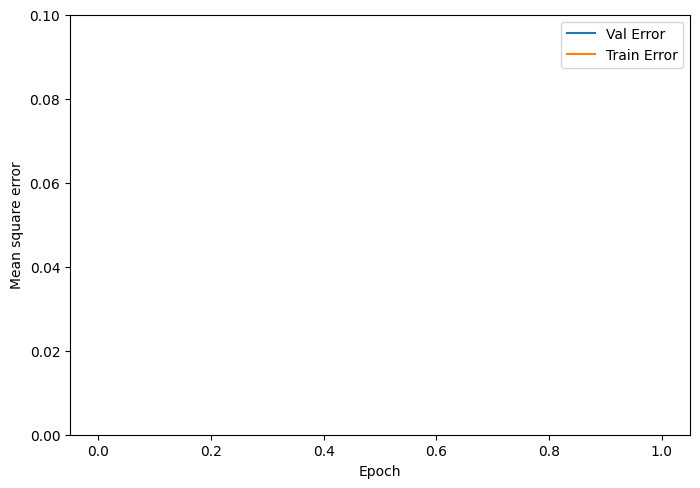

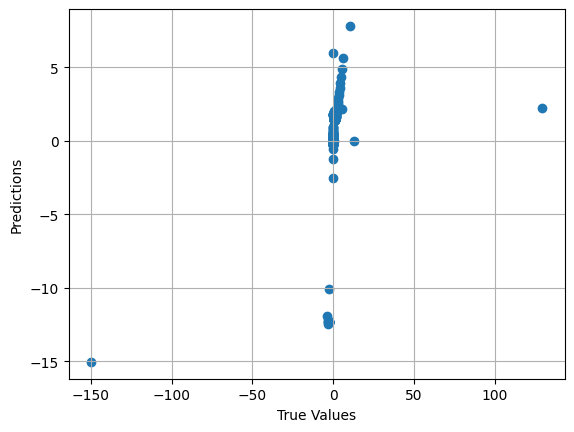

In [5]:
### check val_loss with epoch
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

### plot mse (training and validation)
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean square error')
    plt.plot(hist['epoch'], hist['val_loss'],
        label='Val Error')
    plt.plot(hist['epoch'], hist['loss_tot'],
        label='Train Error')
    plt.ylim(0,0.1)
    plt.legend()
    plt.show()
    
plot_history(history)

### scatter graph
model.load_weights(checkpoint_path)

x_pinn_test=x_pinn[:,0:20]
y_pinn_test=y_pinn[:,0:1]

train_predictions_ux = model.net_a(x_pinn_test)

plt.scatter(y_pinn_test, train_predictions_ux)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)


In [6]:
### Prediction instruction example
st = 0.001 # starting time [s], do not change!
dt = 0.001 # timestep [s], do not change!
nt = 200 # number of timestep [-], do not change!

In [7]:
for nti in range(0,nt):
    tnow = st + dt*nti
    tnow = "{:g}".format(tnow)
    
    if nti == 0: # Dataset load in first timestep
        ### Dataset load
        filename_openfoam = '/home/ubuntu/dambreak/ML/traindata%s.csv'%tnow # you should change the directory

        openfoam = pd.read_csv(filename_openfoam, header = None)
        openfoam_slice = openfoam.drop(0, axis=0).astype(np.float32)
        openfoam_tf = tf.reshape(openfoam_slice, shape =[-1,7])
        openfoam_np = openfoam_tf.numpy()

        alpha_np = openfoam_np[:,1:2]
        p_np = openfoam_np[:,2:3]
        ph_np = openfoam_np[:,3:4]
        U_np = openfoam_np[:,4:6]

        ### domain matrix 생성
        alpha_matrix = np.ones([200,200])
        p_matrix = np.ones([200,200])
        ph_matrix = np.ones([200,200])
        ux_matrix = np.ones([200,200])
        uy_matrix = np.ones([200,200])

        for i in range(0, grid_number):
            ngrid_x = Ngrid_xnp[i]
            ngrid_y = Ngrid_ynp[i]
            alpha_matrix[ngrid_x-1,ngrid_y-1] = alpha_np[i,0]
            p_matrix[ngrid_x-1,ngrid_y-1] = p_np[i,0]
            ph_matrix[ngrid_x-1,ngrid_y-1] = ph_np[i,0]
            ux_matrix[ngrid_x-1,ngrid_y-1] = U_np[i,0]
            uy_matrix[ngrid_x-1,ngrid_y-1] = U_np[i,1]

        ux_matrix = ux_matrix * alpha_matrix
        uy_matrix = uy_matrix * alpha_matrix
        
        globals()['alpha_matrix_'+str(tnow)] = alpha_matrix
        globals()['p_matrix_'+str(tnow)] = p_matrix   # global variable
        globals()['ph_matrix_'+str(tnow)] = ph_matrix
        globals()['ux_matrix_'+str(tnow)] = ux_matrix
        globals()['uy_matrix_'+str(tnow)] = uy_matrix

        ### ML dataset production
        ngrid_x_zp = grid_number_x + 2; ngrid_y_zp = grid_number_y +2

        p_ml = np.ones([grid_number, 5]); ph_ml = np.ones([grid_number, 5]); ux_ml = np.ones([grid_number, 5]); uy_ml = np.ones([grid_number, 5]); alpha_ml = np.ones([grid_number, 5])
        p_matrix_zp = np.zeros([ngrid_x_zp,ngrid_y_zp]); ph_matrix_zp = np.zeros([ngrid_x_zp,ngrid_y_zp]); ux_matrix_zp = np.zeros([ngrid_x_zp,ngrid_y_zp]); uy_matrix_zp = np.zeros([ngrid_x_zp,ngrid_y_zp]); alpha_matrix_zp = np.zeros([ngrid_x_zp,ngrid_y_zp]) # zero padding
        p_matrix_zp[1:ngrid_x_zp-1, 1:ngrid_y_zp-1] = p_matrix; ph_matrix_zp[1:ngrid_x_zp-1, 1:ngrid_y_zp-1] = ph_matrix; ux_matrix_zp[1:ngrid_x_zp-1, 1:ngrid_y_zp-1] = ux_matrix; uy_matrix_zp[1:ngrid_x_zp-1, 1:ngrid_y_zp-1] = uy_matrix; alpha_matrix_zp[1:ngrid_x_zp-1, 1:ngrid_y_zp-1] = alpha_matrix

        k = 0
        for i in range(1, 201):  # default (bc grid 제외 x)
            for j in range(1,201): # default (bc grid 제외 x)
                p_ml[k,0] = p_matrix_zp[i,j]; p_ml[k,1] = p_matrix_zp[i-1,j]; p_ml[k,2] = p_matrix_zp[i+1,j]; p_ml[k,3] = p_matrix_zp[i,j-1]; p_ml[k,4] = p_matrix_zp[i,j+1];
                ph_ml[k,0] = ph_matrix_zp[i,j]; ph_ml[k,1] = ph_matrix_zp[i-1,j]; ph_ml[k,2] = ph_matrix_zp[i+1,j]; ph_ml[k,3] = ph_matrix_zp[i,j-1]; ph_ml[k,4] = ph_matrix_zp[i,j+1];
                ux_ml[k,0] = ux_matrix_zp[i,j]; ux_ml[k,1] = ux_matrix_zp[i-1,j]; ux_ml[k,2] = ux_matrix_zp[i+1,j]; ux_ml[k,3] = ux_matrix_zp[i,j-1]; ux_ml[k,4] = ux_matrix_zp[i,j+1];
                uy_ml[k,0] = uy_matrix_zp[i,j]; uy_ml[k,1] = uy_matrix_zp[i-1,j]; uy_ml[k,2] = uy_matrix_zp[i+1,j]; uy_ml[k,3] = uy_matrix_zp[i,j-1]; uy_ml[k,4] = uy_matrix_zp[i,j+1];
                alpha_ml[k,0] = alpha_matrix_zp[i,j]; alpha_ml[k,1] = alpha_matrix_zp[i-1,j]; alpha_ml[k,2] = alpha_matrix_zp[i+1,j]; alpha_ml[k,3] = alpha_matrix_zp[i,j-1]; alpha_ml[k,4] = alpha_matrix_zp[i,j+1];
                k=k+1

        ml_dataset_pre = np.concatenate((alpha_ml,ph_ml,ux_ml,uy_ml),axis = 1)

    else: # for ther timestpes
        
        
        filename_openfoam = '/home/ubuntu/dambreak/ML/traindata%s.csv'%tnow # you should change the directory

        openfoam = pd.read_csv(filename_openfoam, header = None)
        openfoam_slice = openfoam.drop(0, axis=0).astype(np.float32)
        openfoam_tf = tf.reshape(openfoam_slice, shape =[-1,7])
        openfoam_np = openfoam_tf.numpy()

        alpha_np = openfoam_np[:,1:2]
        p_np = openfoam_np[:,2:3]
        ph_np = openfoam_np[:,3:4]
        U_np = openfoam_np[:,4:6]

        ### domain matrix 
        alpha_matrix = np.ones([200,200])
        p_matrix = np.ones([200,200])
        ph_matrix = np.ones([200,200])
        ux_matrix = np.ones([200,200])
        uy_matrix = np.ones([200,200])

        for i in range(0, grid_number):
            ngrid_x = Ngrid_xnp[i]
            ngrid_y = Ngrid_ynp[i]
            alpha_matrix[ngrid_x-1,ngrid_y-1] = alpha_np[i,0]
            p_matrix[ngrid_x-1,ngrid_y-1] = p_np[i,0]
            ph_matrix[ngrid_x-1,ngrid_y-1] = ph_np[i,0]
            ux_matrix[ngrid_x-1,ngrid_y-1] = U_np[i,0]
            uy_matrix[ngrid_x-1,ngrid_y-1] = U_np[i,1]

        ux_matrix = ux_matrix * alpha_matrix
        uy_matrix = uy_matrix * alpha_matrix
        
        globals()['alpha_matrix_true_'+str(tnow)] = alpha_matrix
        globals()['p_matrix_true_'+str(tnow)] = p_matrix   # global variable
        globals()['ph_matrix_true_'+str(tnow)] = ph_matrix
        globals()['ux_matrix_true_'+str(tnow)] = ux_matrix
        globals()['uy_matrix_ture'+str(tnow)] = uy_matrix
        

        # Continous ML prediction ml_t -> ml_t+1
        p_ml_new = np.ones([grid_number, 5]); ph_ml_new = np.ones([grid_number, 5]); ux_ml_new = np.ones([grid_number, 5]); uy_ml_new = np.ones([grid_number, 5]); alpha_ml_new = np.ones([grid_number, 5])
        p_matrix_zp = np.zeros([ngrid_x_zp,ngrid_y_zp]); ph_matrix_zp = np.zeros([ngrid_x_zp,ngrid_y_zp]); ux_matrix_zp = np.zeros([ngrid_x_zp,ngrid_y_zp]); uy_matrix_zp = np.zeros([ngrid_x_zp,ngrid_y_zp]); alpha_matrix_zp = np.zeros([ngrid_x_zp,ngrid_y_zp]) # zero padding
        p_matrix_zp[1:ngrid_x_zp-1, 1:ngrid_y_zp-1] = p_matrix; ph_matrix_zp[1:ngrid_x_zp-1, 1:ngrid_y_zp-1] = ph_matrix_new; ux_matrix_zp[1:ngrid_x_zp-1, 1:ngrid_y_zp-1] = ux_matrix_new; uy_matrix_zp[1:ngrid_x_zp-1, 1:ngrid_y_zp-1] = uy_matrix_new; alpha_matrix_zp[1:ngrid_x_zp-1, 1:ngrid_y_zp-1] = a_matrix_new

        k = 0
        for i in range(1, 201):  # default (bc grid 제외 x)
            for j in range(1,201): # default (bc grid 제외 x)
                p_ml_new[k,0] = p_matrix_zp[i,j]; p_ml_new[k,1] = p_matrix_zp[i-1,j]; p_ml_new[k,2] = p_matrix_zp[i+1,j]; p_ml_new[k,3] = p_matrix_zp[i,j-1]; p_ml_new[k,4] = p_matrix_zp[i,j+1];
                ph_ml_new[k,0] = ph_matrix_zp[i,j]; ph_ml_new[k,1] = ph_matrix_zp[i-1,j]; ph_ml_new[k,2] = ph_matrix_zp[i+1,j]; ph_ml_new[k,3] = ph_matrix_zp[i,j-1]; ph_ml_new[k,4] = ph_matrix_zp[i,j+1];
                ux_ml_new[k,0] = ux_matrix_zp[i,j]; ux_ml_new[k,1] = ux_matrix_zp[i-1,j]; ux_ml_new[k,2] = ux_matrix_zp[i+1,j]; ux_ml_new[k,3] = ux_matrix_zp[i,j-1]; ux_ml_new[k,4] = ux_matrix_zp[i,j+1];
                uy_ml_new[k,0] = uy_matrix_zp[i,j]; uy_ml_new[k,1] = uy_matrix_zp[i-1,j]; uy_ml_new[k,2] = uy_matrix_zp[i+1,j]; uy_ml_new[k,3] = uy_matrix_zp[i,j-1]; uy_ml_new[k,4] = uy_matrix_zp[i,j+1];
                alpha_ml_new[k,0] = alpha_matrix_zp[i,j]; alpha_ml_new[k,1] = alpha_matrix_zp[i-1,j]; alpha_ml_new[k,2] = alpha_matrix_zp[i+1,j]; alpha_ml_new[k,3] = alpha_matrix_zp[i,j-1]; alpha_ml_new[k,4] = alpha_matrix_zp[i,j+1];
                k=k+1

                
        ml_dataset_pre  = np.concatenate((alpha_ml_new,ph_ml_new,ux_ml_new,uy_ml_new),axis = 1)

    ml_dataset_pd = pd.DataFrame(ml_dataset_pre)
    normed_pred_data = norm(ml_dataset_pd)
    normed_pred_data_re= tf.reshape(normed_pred_data, shape=[-1,20])

    x_pred = normed_pred_data_re

    model.load_weights(checkpoint_path)
    train_predictions_a = model.net_a(x_pred)
    train_predictions_ph = model.net_ph(x_pred)
    train_predictions_ux = model.net_u(x_pred)
    train_predictions_uy = model.net_v(x_pred)

    train_predictions_tot = tf.concat([train_predictions_a, train_predictions_ph, train_predictions_ux, train_predictions_uy], axis = 1)
    train_predictions_pd = pd.DataFrame(train_predictions_tot)

    denorm_predictions_tot = denorm_label(train_predictions_pd)
    denorm_predictions_tot_re = tf.reshape(denorm_predictions_tot, shape = [-1,4])

    denorm_train_predictions_a = np.reshape(denorm_predictions_tot_re[:, 0:1], (-1,1))
    denorm_train_predictions_ph = np.reshape(denorm_predictions_tot_re[:, 1:2], (-1,1)) # tf와 np가 같이 연산되면 오래걸림 -> np 포맷으로 통일
    denorm_train_predictions_ux = np.reshape(denorm_predictions_tot_re[:, 2:3], (-1,1))
    denorm_train_predictions_uy = np.reshape(denorm_predictions_tot_re[:, 3:4], (-1,1))

    a_new = ml_dataset_pre[:, 0:1] + denorm_train_predictions_a 
    ph_new = ml_dataset_pre[:, 5:6] + denorm_train_predictions_ph 
    ux_new = ml_dataset_pre[:, 10:11] + denorm_train_predictions_ux
    uy_new = ml_dataset_pre[:, 15:16] + denorm_train_predictions_uy

    a_matrix_new_c = np.zeros([200,200])
    ph_matrix_new_c = np.zeros([200,200])
    ux_matrix_new_c = np.zeros([200,200])
    uy_matrix_new_c = np.zeros([200,200])

    k = 0
    for i in range(0, 200):
        for j in range(0,200):
            a_matrix_new_c[i,j] = a_new[k,0]
            ph_matrix_new_c[i,j] = ph_new[k,0]
            ux_matrix_new_c[i,j] = ux_new[k,0]
            uy_matrix_new_c[i,j] = uy_new[k,0]
            k = k+1

    a_matrix_new = a_matrix_new_c
    ph_matrix_new = ph_matrix_new_c # CFD+ML일 경우 수정
    ux_matrix_new = ux_matrix_new_c
    uy_matrix_new = uy_matrix_new_c

    globals()['a_matrix_pred_'+str(tnow)] = a_matrix_new
    globals()['ph_matrix_pred_'+str(tnow)] = ph_matrix_new   # global variable
    globals()['ux_matrix_pred_'+str(tnow)] = ux_matrix_new
    globals()['uy_matrix_pred_'+str(tnow)] = uy_matrix_new
    print(tnow)
    

0.001
0.002


In [8]:
a_matrix_diff_002 = (globals()['alpha_matrix_true_0.002'] - globals()['a_matrix_pred_0.002'])*(globals()['alpha_matrix_true_0.002'] - globals()['a_matrix_pred_0.002'])

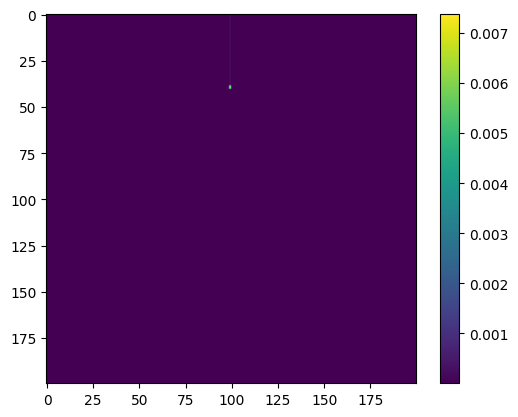

In [9]:
plt.imshow(a_matrix_diff_002)
plt.colorbar()
#plt.clim(0,0.0000001)
plt.show()